In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

from npiv import iv_simulator, custom_objectives, model_wrapper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# 0. random data.  price is endogenous, instrument is this 
n = 10000 # number of observations
d = 2 # dimensionality of the exogenous regressors in x
    
ivsim = iv_simulator.IVSimulator(num_exog_x_cols=d)
df = ivsim.generate_data(num_obs=n)
df['id'] = np.arange(n)

In [8]:
df.head()

,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id
0,-1.085631,0.997345,-2.911176,-0.062427,0.358411,0.075597,0.434008,-3.001299,0
1,0.282978,-1.506295,-3.156704,-0.865015,-0.484068,0.055417,-0.428650,0.365224,1
2,-0.578600,1.651437,-1.748911,0.758610,1.606738,-0.025814,1.580924,-1.169309,2
3,-2.426679,-0.428913,-3.764864,-2.019208,-1.710488,-0.012513,-1.723001,4.389678,3
4,1.265936,-0.866740,-4.289064,0.282274,0.547740,-0.091385,0.456354,-0.240278,4


In [9]:
print(ivsim.exog_x_cols, ivsim.endog_x_col, ivsim.instrument_col, ivsim.y_col)
display(ivsim.log_cost_coefs)
display(ivsim.log_sales_coefs)
display(df.describe())

['x_0', 'x_1'] log_price instrument log_sales


x_0    0.707107
x_1    0.707107
dtype: float64

x_0          0.707107
x_1          0.707107
log_price   -4.000000
dtype: float64

,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.018369,0.001719,-3.998095,0.014204,0.424120,0.000942,0.425062,-1.263862,4999.50000
std,1.003899,0.996794,1.609220,1.013633,1.058928,0.057623,1.060207,3.620433,2886.89568
min,-3.801378,-3.685499,-6.798997,-3.492599,-3.127753,-0.099983,-3.132122,-17.948572,0.00000
25%,-0.666906,-0.686832,-5.394813,-0.676062,-0.306594,-0.048520,-0.304092,-3.116390,2499.75000
50%,0.014632,0.009468,-4.007687,0.001468,0.411439,0.001735,0.409161,-1.363713,4999.50000
75%,0.683905,0.681603,-2.616799,0.696894,1.137529,0.050727,1.136885,0.653906,7499.25000
max,3.676205,4.068097,-1.200855,3.628798,4.165641,0.099975,4.088933,14.160886,9999.00000


In [10]:
# 4. now compute some true quantiles
log_price_qtl_cols = []
interval = .1
qtls = np.arange(0,1,interval) + interval/2
print("computing these conditional quantiles of log price: {}".format(qtls))
for qtl in qtls:
    qcol = 'log_price_qtl_{:.3f}'.format(qtl)
    df[qcol] = ivsim.compute_log_price_quantile_given_cost_and_instrument(df['unobserved_log_cost'], df['instrument'], qtl)
    log_price_qtl_cols.append(qcol)
print("these are the relevant columns: {}".format(log_price_qtl_cols))

computing these conditional quantiles of log price: [ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95]
these are the relevant columns: ['log_price_qtl_0.050', 'log_price_qtl_0.150', 'log_price_qtl_0.250', 'log_price_qtl_0.350', 'log_price_qtl_0.450', 'log_price_qtl_0.550', 'log_price_qtl_0.650', 'log_price_qtl_0.750', 'log_price_qtl_0.850', 'log_price_qtl_0.950']


In [11]:
# 5. construct data for doing deepiv with these true quantiles
#    this will involve just duplicating the data a bunch of times,
#    each time for each quantile of log price
dfs_to_concat = []
for c in log_price_qtl_cols:
    tmp_df = df[['id']+ivsim.exog_x_cols+[c]+[ivsim.y_col]].rename(columns={c:'log_price_synthetic'})
    dfs_to_concat.append(tmp_df)
df_long = pd.concat(dfs_to_concat).reset_index(drop=True)

In [12]:
# 6. check linear custom objective still works here just to be sure
from scipy.optimize import minimize
# now actually optimize it. takes maybe a minute to finish?
tmp_xcols = ivsim.exog_x_cols+['log_price_synthetic']
min_output = minimize(fun = custom_objectives.grouped_sse_loss_linear, 
                      x0=np.zeros(shape=len(tmp_xcols)+1), 
                      args = (df_long, tmp_xcols, ivsim.y_col, 'id'))
# compare with truth.  doesn't look too bad.
pd.DataFrame({'true coefs': ivsim.log_sales_coefs, 'linear NPIV coefs':min_output.x[1:]})

,true coefs,linear NPIV coefs
x_0,0.707107,0.536132
x_1,0.707107,0.514787
log_price,-4.000000,-3.770611


In [14]:
df.head()

,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id,log_price_qtl_0.050,log_price_qtl_0.150,log_price_qtl_0.250,log_price_qtl_0.350,log_price_qtl_0.450,log_price_qtl_0.550,log_price_qtl_0.650,log_price_qtl_0.750,log_price_qtl_0.850,log_price_qtl_0.950
0,-1.085631,0.997345,-2.911176,-0.062427,0.358411,0.075597,0.434008,-3.001299,0,0.179667,0.196835,0.217964,0.244612,0.279280,0.326262,0.393634,0.498678,0.686899,1.139181
1,0.282978,-1.506295,-3.156704,-0.865015,-0.484068,0.055417,-0.428650,0.365224,1,-0.643101,-0.625933,-0.604803,-0.578155,-0.543488,-0.496506,-0.429134,-0.324090,-0.135869,0.316413
2,-0.578600,1.651437,-1.748911,0.758610,1.606738,-0.025814,1.580924,-1.169309,2,0.899293,0.916461,0.937591,0.964239,0.998906,1.045888,1.113260,1.218304,1.406525,1.858807
3,-2.426679,-0.428913,-3.764864,-2.019208,-1.710488,-0.012513,-1.723001,4.389678,3,-1.865225,-1.848057,-1.826927,-1.800279,-1.765612,-1.718630,-1.651258,-1.546214,-1.357992,-0.905710
4,1.265936,-0.866740,-4.289064,0.282274,0.547740,-0.091385,0.456354,-0.240278,4,0.357385,0.374554,0.395683,0.422331,0.456998,0.503981,0.571353,0.676397,0.864618,1.316900


In [17]:
df_long_original = df_long.copy()

# effect of qtl noise

In [8]:
print(df_long.columns)
print(df_long.shape, len(df_long['id'].unique()))
display(df_long.tail())

Index(['id', 'x_0', 'x_1', 'log_price_synthetic', 'log_sales'], dtype='object')
(100000, 5) 10000


,id,x_0,x_1,log_price_synthetic,log_sales
99995,9995,0.908597,0.720665,2.305681,-2.297293
99996,9996,0.409403,0.478726,1.754225,-1.954046
99997,9997,0.837064,-0.947254,0.959748,-1.695108
99998,9998,-0.258611,-1.402840,-0.055182,-1.762586
99999,9999,1.044541,0.369281,2.149036,-7.521199


In [27]:
def evaluate_qtl_error_impact(df_long, mu=0, sigma=0):
    
    df_long=df_long.copy()

    # noise up the quantiles
    df_long['log_price_synthetic'] += np.random.normal(loc=mu, scale=sigma)

    # divide into train/val/test
    train_cutoff = int(n*.5)
    val_cutoff = int(n*.7)
    df_train = df_long.loc[df_long['id']<train_cutoff, :]
    df_val = df_long.loc[(df_long['id']>=train_cutoff)&(df_long['id']<val_cutoff), :]
    df_test = df.loc[df['id']>=val_cutoff, :].rename(columns={'log_price':'log_price_synthetic'})
    print(df_train.shape, df_val.shape, df_test.shape)

    # construct lgb.datasets for prediction
    x_cols = ivsim.exog_x_cols + ['log_price_synthetic']
    y_col = ivsim.y_col
    print(x_cols, y_col)
    dat_train = lgb.Dataset(df_train[x_cols], label=df_train[y_col])
    dat_train.grouper = df_train['id']
    dat_val = lgb.Dataset(df_val[x_cols], label=df_val[y_col])
    dat_val.grouper = df_val['id']


    # ok, now let's try the custom objective
    num_iters = 10000
    print_every = max(num_iters//20, 10)
    print(num_iters, print_every)

    # try training
    params = {
        'num_threads':4,
        'objective': None,
        'metric': None,
        'num_leaves': 5,
        'learning_rate': 0.2,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'max_delta_step':.1,
        'min_gain_to_split':10,
    }
    eval_results={}
    gbm2 = lgb.train(params, train_set=dat_train, valid_sets=[dat_train, dat_val], valid_names=['train', 'val'],
                    num_boost_round=num_iters, verbose_eval=print_every,
                    fobj = lambda preds, dataset: 
                             custom_objectives.grouped_sse_loss_grad_hess(preds, dataset.label, dataset.grouper),
                    feval = lambda preds, dataset: 
                             ('grouped sse',
                                custom_objectives.grouped_sse_loss(preds, dataset.label, dataset.grouper),
                                False),
                     callbacks=[lgb.record_evaluation(eval_results)]
                    )

    # print some marginal effects
    wrapped_gbm2 = model_wrapper.ModelWrapper(gbm2)
    marginal_fx = wrapped_gbm2.marginal_effect_plots(df_test, plot=False)
    display(marginal_fx.groupby('feature name').describe().transpose())

    # generate time series of marginal effects
    dfs_to_concat = []
    for num_iteration in np.linspace(1,num_iters, 50, dtype=int):
    #     print(num_iteration)
        mfx = wrapped_gbm2.marginal_effect_plots(df_test, plot=False, predict_kwargs={'num_iteration':num_iteration})
        tmp_df = mfx.groupby('feature name').describe().transpose().reset_index(level=0,drop=True)\
                    .reset_index().rename(columns={'index':'stat'})
        tmp_df.columns.name=None
        tmp_df['num_iteration'] = num_iteration
        tmp_df.set_index(['num_iteration', 'stat'], inplace=True)
    #     display(tmp_df)
        dfs_to_concat.append(tmp_df)
    desc_df = pd.concat(dfs_to_concat)

    fig, axes = plt.subplots(nrows=desc_df.shape[1]+1, ncols=1, figsize=(10, (desc_df.shape[1]+1)*1.5), sharex=True)
    # plot performance
    ax = axes[0]
    ax.grid()
    perfs = eval_results['val']['grouped sse']
    best_num_trees = np.argmin(perfs)
    ax.plot(eval_results['val']['grouped sse'], color='#555555')
    ax.axvline(best_num_trees, color='blue', linewidth=1)
    ax.set_yscale('log')
    ax.set_title("validation set performance, blue=best")

    # plot marginal effects
    for i,c in enumerate(desc_df.columns):
        tmp_df = desc_df.loc[pd.IndexSlice[:, ['mean', 'min', 'max', '25%', '75%']],c].unstack()
        ax = axes[i+1]
        ax.grid()
        # plot the true marginal effects
        if c=='log_price_synthetic':
            true_mfx = ivsim.log_sales_coefs.loc['log_price']
        else:
            true_mfx = ivsim.log_sales_coefs.loc[c]
        ax.axhline(true_mfx, color='red', linewidth=1)
        ax.axvline(best_num_trees, color='blue', linewidth=1)
        # plot the model implied marignal effects
        ax.plot(tmp_df['mean'], color='black', linestyle='-')
        ax.plot(tmp_df['25%'], color='black', linestyle='-.')
        ax.plot(tmp_df['75%'], color='black', linestyle='-.')
        ax.set_title('mean and quartiles of marginal effects of `{}`, red = truth'.format(c))
    plt.xlabel("number of trees trained")
    plt.tight_layout()

(50000, 5) (20000, 5) (3000, 19)
['x_0', 'x_1', 'log_price_synthetic'] log_sales
10000 500
[500]	train's grouped sse: 1.70528e+06	val's grouped sse: 769660
[1000]	train's grouped sse: 1.61289e+06	val's grouped sse: 808458
[1500]	train's grouped sse: 1.57734e+06	val's grouped sse: 825221
[2000]	train's grouped sse: 1.55725e+06	val's grouped sse: 840312
[2500]	train's grouped sse: 1.54558e+06	val's grouped sse: 850311
[3000]	train's grouped sse: 1.53907e+06	val's grouped sse: 857866
[3500]	train's grouped sse: 1.5338e+06	val's grouped sse: 863463
[4000]	train's grouped sse: 1.53072e+06	val's grouped sse: 865006
[4500]	train's grouped sse: 1.52811e+06	val's grouped sse: 870156
[5000]	train's grouped sse: 1.52569e+06	val's grouped sse: 868006
[5500]	train's grouped sse: 1.52375e+06	val's grouped sse: 869557
[6000]	train's grouped sse: 1.52219e+06	val's grouped sse: 868860
[6500]	train's grouped sse: 1.52039e+06	val's grouped sse: 869730
[7000]	train's grouped sse: 1.51923e+06	val's grouped

feature name           log_price_synthetic          x_0          x_1
marginal effect count          3000.000000  3000.000000  3000.000000
                mean             -3.788094     0.575938     0.460489
                std               9.208127     3.142578     2.969033
                min             -38.614154   -15.036677    -9.390947
                25%              -9.192302    -1.652446    -1.447928
                50%              -4.228282     0.605125     0.328834
                75%               1.528779     2.713907     2.330804
                max              31.259800    11.444552    11.045441

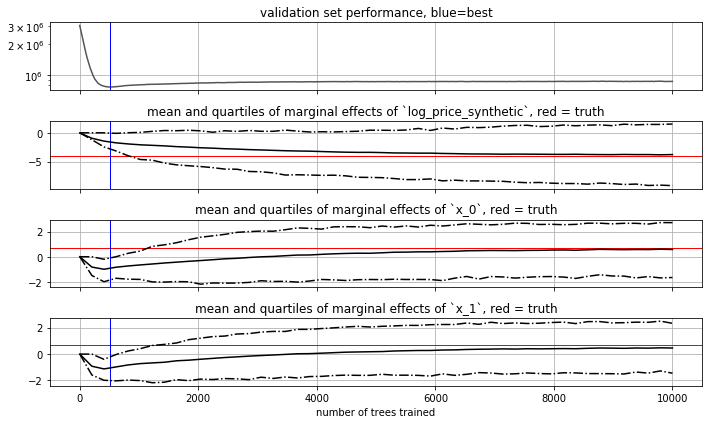

In [28]:
evaluate_qtl_error_impact(df_long, mu=0, sigma=0)

(50000, 5) (20000, 5) (3000, 19)
['x_0', 'x_1', 'log_price_synthetic'] log_sales
10000 500
[500]	train's grouped sse: 1.70484e+06	val's grouped sse: 769228
[1000]	train's grouped sse: 1.61204e+06	val's grouped sse: 809571
[1500]	train's grouped sse: 1.57771e+06	val's grouped sse: 825060
[2000]	train's grouped sse: 1.55797e+06	val's grouped sse: 840789
[2500]	train's grouped sse: 1.54648e+06	val's grouped sse: 852299
[3000]	train's grouped sse: 1.53925e+06	val's grouped sse: 855042
[3500]	train's grouped sse: 1.5341e+06	val's grouped sse: 861216
[4000]	train's grouped sse: 1.53098e+06	val's grouped sse: 865959
[4500]	train's grouped sse: 1.52806e+06	val's grouped sse: 869118
[5000]	train's grouped sse: 1.52582e+06	val's grouped sse: 870252
[5500]	train's grouped sse: 1.52383e+06	val's grouped sse: 870478
[6000]	train's grouped sse: 1.52209e+06	val's grouped sse: 869183
[6500]	train's grouped sse: 1.52064e+06	val's grouped sse: 871618
[7000]	train's grouped sse: 1.51946e+06	val's grouped

feature name           log_price_synthetic          x_0          x_1
marginal effect count          3000.000000  3000.000000  3000.000000
                mean             -3.719330     0.597683     0.499391
                std               9.308192     3.144445     3.000774
                min             -38.864361   -14.710850    -9.620294
                25%              -9.827892    -1.634415    -1.420135
                50%              -4.554964     0.604638     0.452923
                75%               1.926871     2.715382     2.393038
                max              26.069192    11.746523    11.380410

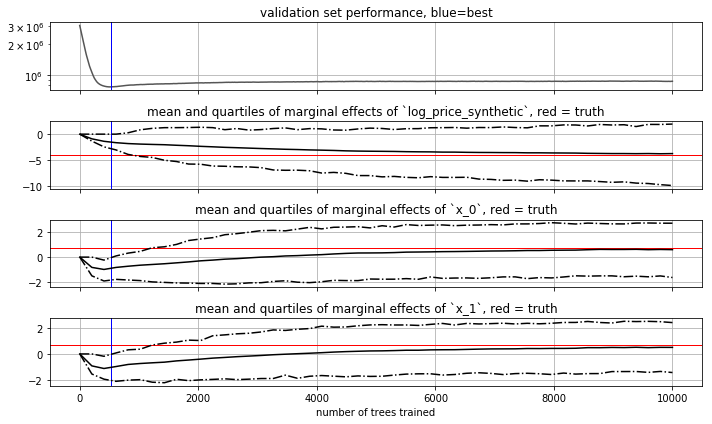

In [29]:
evaluate_qtl_error_impact(df_long, mu=0, sigma=.1)
# performance doesn't seem to suffer...?

(50000, 5) (20000, 5) (3000, 19)
['x_0', 'x_1', 'log_price_synthetic'] log_sales
10000 500
[500]	train's grouped sse: 1.70487e+06	val's grouped sse: 769787
[1000]	train's grouped sse: 1.61165e+06	val's grouped sse: 808065
[1500]	train's grouped sse: 1.57591e+06	val's grouped sse: 823694
[2000]	train's grouped sse: 1.55562e+06	val's grouped sse: 839948
[2500]	train's grouped sse: 1.54379e+06	val's grouped sse: 851017
[3000]	train's grouped sse: 1.53667e+06	val's grouped sse: 855586
[3500]	train's grouped sse: 1.53111e+06	val's grouped sse: 864339
[4000]	train's grouped sse: 1.52729e+06	val's grouped sse: 864460
[4500]	train's grouped sse: 1.52414e+06	val's grouped sse: 867445
[5000]	train's grouped sse: 1.52141e+06	val's grouped sse: 868396
[5500]	train's grouped sse: 1.51923e+06	val's grouped sse: 870942
[6000]	train's grouped sse: 1.51701e+06	val's grouped sse: 870199
[6500]	train's grouped sse: 1.51526e+06	val's grouped sse: 874259
[7000]	train's grouped sse: 1.51352e+06	val's groupe

feature name           log_price_synthetic          x_0          x_1
marginal effect count          3000.000000  3000.000000  3000.000000
                mean             -3.351123     0.637352     0.523864
                std              10.693515     3.121448     3.009704
                min             -37.146219   -14.212597    -9.753945
                25%              -9.730998    -1.516012    -1.386470
                50%              -3.772354     0.567664     0.354711
                75%               2.386442     2.757281     2.493411
                max              28.923533    12.082189    11.142298

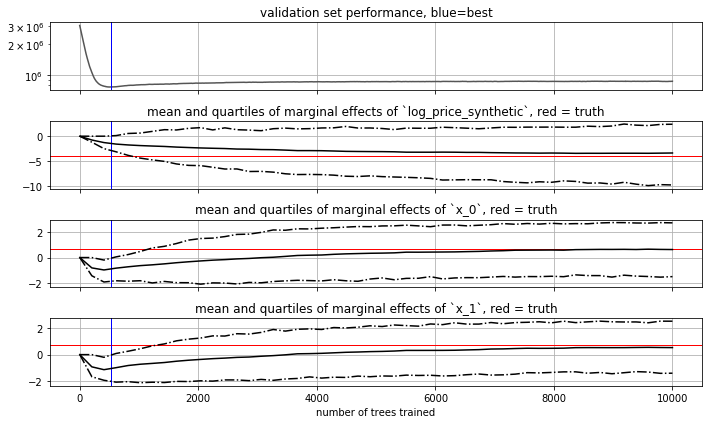

In [30]:
evaluate_qtl_error_impact(df_long, mu=0, sigma=1)

In [ ]:
# seems like noising up the qtls makes estimates more variable, but still centered around the truth

(50000, 5) (20000, 5) (3000, 19)
['x_0', 'x_1', 'log_price_synthetic'] log_sales
10000 500
[500]	train's grouped sse: 1.70391e+06	val's grouped sse: 769903
[1000]	train's grouped sse: 1.61077e+06	val's grouped sse: 806776
[1500]	train's grouped sse: 1.575e+06	val's grouped sse: 826499
[2000]	train's grouped sse: 1.55494e+06	val's grouped sse: 839836
[2500]	train's grouped sse: 1.54345e+06	val's grouped sse: 850315
[3000]	train's grouped sse: 1.53628e+06	val's grouped sse: 857706
[3500]	train's grouped sse: 1.53027e+06	val's grouped sse: 863330
[4000]	train's grouped sse: 1.52672e+06	val's grouped sse: 862650
[4500]	train's grouped sse: 1.52309e+06	val's grouped sse: 869063
[5000]	train's grouped sse: 1.52037e+06	val's grouped sse: 867986
[5500]	train's grouped sse: 1.51834e+06	val's grouped sse: 870453
[6000]	train's grouped sse: 1.51628e+06	val's grouped sse: 871013
[6500]	train's grouped sse: 1.51428e+06	val's grouped sse: 872297
[7000]	train's grouped sse: 1.51274e+06	val's grouped 

feature name           log_price_synthetic          x_0          x_1
marginal effect count          3000.000000  3000.000000  3000.000000
                mean             -3.744583     0.662846     0.546457
                std               9.581375     3.128707     3.049223
                min             -38.045984   -14.346240    -9.585860
                25%              -9.124495    -1.492195    -1.421863
                50%              -4.588934     0.645012     0.446577
                75%               1.902422     2.714086     2.520056
                max              24.072253    11.613616    11.184651

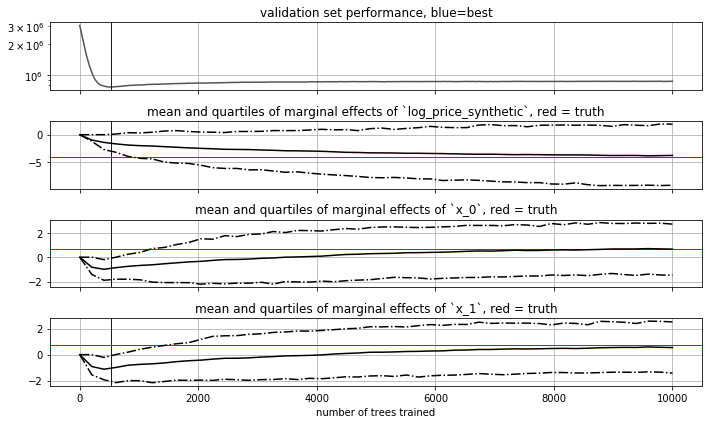

In [31]:
evaluate_qtl_error_impact(df_long, mu=.1, sigma=0)

(50000, 5) (20000, 5) (3000, 19)
['x_0', 'x_1', 'log_price_synthetic'] log_sales
10000 500
[500]	train's grouped sse: 1.70409e+06	val's grouped sse: 770391
[1000]	train's grouped sse: 1.61199e+06	val's grouped sse: 807957
[1500]	train's grouped sse: 1.57616e+06	val's grouped sse: 825996
[2000]	train's grouped sse: 1.55554e+06	val's grouped sse: 839348
[2500]	train's grouped sse: 1.54368e+06	val's grouped sse: 851200
[3000]	train's grouped sse: 1.5363e+06	val's grouped sse: 858007
[3500]	train's grouped sse: 1.53068e+06	val's grouped sse: 860747
[4000]	train's grouped sse: 1.52691e+06	val's grouped sse: 864602
[4500]	train's grouped sse: 1.52383e+06	val's grouped sse: 868931
[5000]	train's grouped sse: 1.52117e+06	val's grouped sse: 867995
[5500]	train's grouped sse: 1.51929e+06	val's grouped sse: 869493
[6000]	train's grouped sse: 1.51692e+06	val's grouped sse: 869513
[6500]	train's grouped sse: 1.51502e+06	val's grouped sse: 871016
[7000]	train's grouped sse: 1.51352e+06	val's grouped

feature name           log_price_synthetic          x_0          x_1
marginal effect count          3000.000000  3000.000000  3000.000000
                mean             -3.487096     0.688838     0.569153
                std              10.923811     3.142352     3.017038
                min             -36.631778   -14.127451    -9.653102
                25%              -9.919568    -1.526344    -1.376574
                50%              -2.986861     0.651366     0.423624
                75%               3.161384     2.797180     2.505086
                max              23.129093    11.932598    11.429642

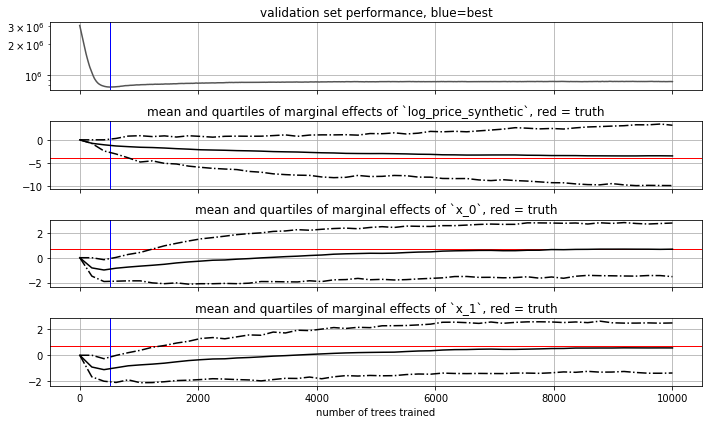

In [32]:
evaluate_qtl_error_impact(df_long, mu=1, sigma=0)

In [ ]:
# effect of a fairly sizeable amount of bias seems to be minimal here.  this is likely because
# margina effects are constantly -4 everywhere; if it were the case that marginal effects
# were nonconstant, we'd expect some issues

(50000, 5) (20000, 5) (3000, 19)
['x_0', 'x_1', 'log_price_synthetic'] log_sales
10000 500
[500]	train's grouped sse: 1.70476e+06	val's grouped sse: 769613
[1000]	train's grouped sse: 1.61304e+06	val's grouped sse: 807235
[1500]	train's grouped sse: 1.57657e+06	val's grouped sse: 823411
[2000]	train's grouped sse: 1.55671e+06	val's grouped sse: 839247
[2500]	train's grouped sse: 1.54481e+06	val's grouped sse: 849817
[3000]	train's grouped sse: 1.53733e+06	val's grouped sse: 856604
[3500]	train's grouped sse: 1.53166e+06	val's grouped sse: 862353
[4000]	train's grouped sse: 1.52802e+06	val's grouped sse: 863399
[4500]	train's grouped sse: 1.52469e+06	val's grouped sse: 868695
[5000]	train's grouped sse: 1.52208e+06	val's grouped sse: 867896
[5500]	train's grouped sse: 1.51979e+06	val's grouped sse: 869228
[6000]	train's grouped sse: 1.5175e+06	val's grouped sse: 868200
[6500]	train's grouped sse: 1.51555e+06	val's grouped sse: 869011
[7000]	train's grouped sse: 1.51426e+06	val's grouped

feature name           log_price_synthetic          x_0          x_1
marginal effect count          3000.000000  3000.000000  3000.000000
                mean              0.043393     0.639342     0.522737
                std               1.842288     3.181381     2.996514
                min             -31.599361   -14.390754    -9.859045
                25%               0.000000    -1.541700    -1.432768
                50%               0.000000     0.703951     0.254885
                75%               0.000000     2.747596     2.465674
                max              14.906578    11.937766    11.365831

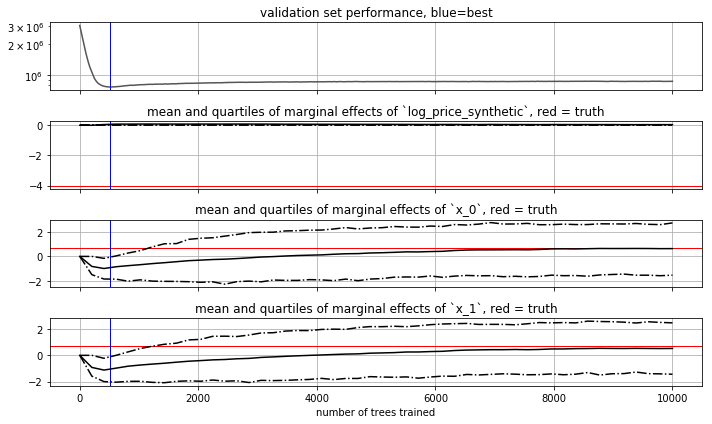

In [34]:
evaluate_qtl_error_impact(df_long, mu=5, sigma=0)

In [ ]:
# jacking up bias too high puts the actual prices out of the training range, which makes these
# effects quite small since lgb is close to 0 if far away from largest mass